In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json

In [528]:
league_id = 135 # Choose the league id

season_file = '2015-2022'

first_season = 2015
last_season = 2022

features = ['HOME_PTS_PCT', 'HOME_WIN_PCT', 'HOME_DRAW_PCT', 'HOME_LOSS_PCT', 'HOME_HOME_WIN_PCT', 'HOME_HOME_DRAW_PCT', 'HOME_HOME_LOSS_PCT', f'HOME_WIN_PCT_LAST_GAMES', f'HOME_DRAW_PCT_LAST_GAMES', f'HOME_LOSS_PCT_LAST_GAMES','HOME_SCORE_LAST_GAMES', 'HOME_CONCEDED_LAST_GAMES', 'HOME_SHOTS_ON_GOAL_LAST_GAMES', 'HOME_SHOTS_OFF_GOAL_LAST_GAMES', 'HOME_TOTAL_SHOTS_LAST_GAMES', 'HOME_BLOCKED_SHOTS_LAST_GAMES','HOME_SHOTS_INSIDE_BOX_LAST_GAMES', 'HOME_SHOTS_OUTSIDE_BOX_LAST_GAMES', 'HOME_FOULS_LAST_GAMES', 'HOME_CORNERS_LAST_GAMES', 'HOME_OFFSIDES_LAST_GAMES','HOME_POSSESSION_LAST_GAMES', 'HOME_YELLOW_CARDS_LAST_GAMES', 'HOME_RED_CARDS_LAST_GAMES', 'HOME_SAVES_LAST_GAMES', 'HOME_TOTAL_PASSES_LAST_GAMES','HOME_PASSES_ACCURATE_LAST_GAMES', 'HOME_PASSES_PCT_LAST_GAMES',
           'AWAY_PTS_PCT', 'AWAY_WIN_PCT', 'AWAY_DRAW_PCT', 'AWAY_LOSS_PCT', 'AWAY_AWAY_WIN_PCT', 'AWAY_AWAY_DRAW_PCT', 'AWAY_AWAY_LOSS_PCT', f'AWAY_WIN_PCT_LAST_GAMES', f'AWAY_DRAW_PCT_LAST_GAMES', f'AWAY_LOSS_PCT_LAST_GAMES','AWAY_SCORE_LAST_GAMES', 'AWAY_CONCEDED_LAST_GAMES', 'AWAY_SHOTS_ON_GOAL_LAST_GAMES', 'AWAY_SHOTS_OFF_GOAL_LAST_GAMES', 'AWAY_TOTAL_SHOTS_LAST_GAMES', 'AWAY_BLOCKED_SHOTS_LAST_GAMES','AWAY_SHOTS_INSIDE_BOX_LAST_GAMES', 'AWAY_SHOTS_OUTSIDE_BOX_LAST_GAMES', 'AWAY_FOULS_LAST_GAMES', 'AWAY_CORNERS_LAST_GAMES', 'AWAY_OFFSIDES_LAST_GAMES','AWAY_POSSESSION_LAST_GAMES', 'AWAY_YELLOW_CARDS_LAST_GAMES', 'AWAY_RED_CARDS_LAST_GAMES', 'AWAY_SAVES_LAST_GAMES', 'AWAY_TOTAL_PASSES_LAST_GAMES','AWAY_PASSES_ACCURATE_LAST_GAMES', 'AWAY_PASSES_PCT_LAST_GAMES']
targets = ['OUTCOME']

min_threshold = 1.8
max_threshold = 10

totals_max_threshold = 55
totals_min_threshold = 45

default_odds_value = 1.9

first_attr_index = 9

# default_stake = 50
bankroll = 2000
stake = 0.025

In [529]:
print('\nGetting data for the model...')

season = "{}-{}".format(first_season, last_season)

default_path = f'./leagues/{league_id}'
whole_dataset = pd.read_csv(f"{default_path}/data/{season_file}.csv")
whole_dataset = whole_dataset.loc[(whole_dataset['HOME_ODDS'].notna()) & (whole_dataset['AWAY_ODDS'].notna())]
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date


Getting data for the model...


In [530]:
whole_dataset.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_POSSESSION_LAST_GAMES,AWAY_YELLOW_CARDS_LAST_GAMES,AWAY_RED_CARDS_LAST_GAMES,AWAY_SAVES_LAST_GAMES,AWAY_TOTAL_PASSES_LAST_GAMES,AWAY_PASSES_ACCURATE_LAST_GAMES,AWAY_PASSES_PCT_LAST_GAMES,OUTCOME,HOME_SCORE,AWAY_SCORE
0,0,196503,2015-10-31,2015,Juventus,Torino,1.60,6.77,3.73,40.000000,...,48.8,2.6,0.4,1.4,415.2,345.2,82.8,H,2,1
1,1,196504,2015-10-31,2015,Inter,AS Roma,2.53,2.85,3.37,70.000000,...,56.2,2.4,0.2,3.4,536.4,456.6,83.0,H,1,0
2,2,196506,2015-11-01,2015,Bologna,Atalanta,2.75,2.79,3.10,20.000000,...,43.6,2.4,0.4,4.8,376.8,293.2,77.0,H,3,0
3,3,196509,2015-11-01,2015,Udinese,Sassuolo,2.31,3.29,3.24,36.666667,...,45.2,3.0,0.2,2.0,377.0,278.0,73.6,D,0,0
4,4,196510,2015-11-01,2015,Lazio,AC Milan,2.02,3.87,3.44,60.000000,...,49.6,2.8,0.2,1.4,425.2,336.8,78.8,A,1,3


In [5]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    path = 'charts'
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.savefig(f"{path}/{title.replace(' ','_').lower()}.png", dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')

def check_bet_worth(prediction, odds_home, odds_away, odds_draw, prob):
    pred_odds = (1/prob)
    return ((prediction == 'H' and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (odds_away > min_threshold and odds_away < max_threshold)) or 
            (prediction == 'D' and (odds_draw > min_threshold and odds_draw < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value, prob):
    game_money = 0
            
#     goal_diff_pred = abs(home_pred_score - away_pred_score)
#     if goal_diff_pred > 0.2 and goal_diff_pred < 0.4:
#         return game_money
    
    if check_bet_worth(prediction, game['HOME_ODDS'], game['AWAY_ODDS'], game['DRAW_ODDS'], prob):
        if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
            game_money = (bet_value*game['HOME_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
            game_money = (bet_value*game['AWAY_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
            game_money = (bet_value*game['DRAW_ODDS'] - bet_value)
        else:
            game_money = -bet_value
            
    return game_money

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

In [6]:
def get_feature_correlation_matrix(dataset):
    print('\nGetting the feature correlation matrix...')

    import seaborn as sns

    try:
        dependent_variables = dataset.iloc[:,first_attr_index:]
        corrmat = dependent_variables.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize=(13,13))
        title = 'Feature Correlation'
        plt.title(title)
        #plot heat map
        sns.set(font_scale=0.6)
        g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show()
    except:
        print('No correlation matrix for the selected model.')

In [7]:
def simulate_by_model(predictions, dataset_itr):
    money_by_date = []
    bets = []
    money_by_team = dict()
    total_invested = 0
    outcome_predictions = {'H': 0, 'A': 0, 'D': 0}
    strikes = 0
    no_value_games = []

    money_by_date.append({
        'date': dataset_itr.iloc[0,2],
        'date_profit': 0,
        'total_bankroll': bankroll
    })

    for index, game in dataset_itr.iterrows():
        bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])
        
        # Next date
        if game['GAME_DATE'] != money_by_date[-1]['date']:
                
            money_by_date.append({
                'date': game['GAME_DATE'],
                'date_profit': 0,
                'total_bankroll': money_by_date[-1]['total_bankroll']
            })

        if game['HOME_TEAM'] not in money_by_team:
            money_by_team[game['HOME_TEAM']] = 0
        if game['AWAY_TEAM'] not in money_by_team:
            money_by_team[game['AWAY_TEAM']] = 0

#         home_score_pred, away_score_pred = predictions[index]
        
#         prediction = 'D'
#         score_pred_diff = abs(home_score_pred - away_score_pred)
#         if home_score_pred > away_score_pred and score_pred_diff > 0.2:
#             prediction = 'H'
#         elif home_score_pred < away_score_pred and score_pred_diff > 0.2:
#             prediction = 'A'

        away_prob, draw_prob, home_prob = predictions[index]
        biggest_prob = max(away_prob, draw_prob, home_prob)
        
        if away_prob == biggest_prob:
            prediction = 'A'
        elif home_prob == biggest_prob:
            prediction = 'H'
        else:
            prediction = 'D'
        
        if prediction == game['OUTCOME']:
            strikes += 1

        game_money_model = 0

#         game_money_model = check_model_performance_on_game(game, prediction, bet_value, home_score_pred, away_score_pred)
        game_money_model = check_model_performance_on_game(game, prediction, bet_value, biggest_prob)

        if game_money_model != 0:       
            if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
                bets.append(['HOME', game['HOME_ODDS'], 1])
                money_by_team[game['HOME_TEAM']] += game_money_model
            elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
                bets.append(['AWAY', game['AWAY_ODDS'], 1])
                money_by_team[game['AWAY_TEAM']] += game_money_model
            elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
                bets.append(['DRAW', game['DRAW_ODDS'], 1])
            else:
                if prediction == 'H':
                    bets.append(['HOME', game['HOME_ODDS'], 0])
                    money_by_team[game['HOME_TEAM']] += game_money_model
                elif prediction == 'A':
                    bets.append(['AWAY', game['AWAY_ODDS'], 0])
                    money_by_team[game['AWAY_TEAM']] += game_money_model
                elif prediction == 'D':
                    bets.append(['DRAW', game['DRAW_ODDS'], 0])

            total_invested += bet_value

        outcome_predictions[prediction] += 1

        money_by_date[-1]['date_profit'] += game_money_model
        money_by_date[-1]['total_bankroll'] += game_money_model
        
    return {
        'results': money_by_date,
        'outcome_distribution': outcome_predictions,
        'bets': bets,
        'profit_by_team': money_by_team,
        'total_invested': total_invested,
        'strike_rate': strikes * 100 / len(dataset_itr.index),
    }


In [8]:
def save_league_season_results(result, season_train, season_test):
    path = f"leagues/{league_id}/results/regression"
    file_name = f"{season_train}-{season_test}.json"

    if not os.path.exists(path):
        os.makedirs(path)

    with open(f"{path}/{file_name}", 'w') as f:
        json.dump(result['results'], f, indent = 4, sort_keys = True, default = str)

In [633]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

def train_model(dataset):
    X = dataset.loc[:, features]
    y = dataset[targets]
    
# #     " Random Search CV Optmizer "
#     classifier = RandomForestClassifier()
    
#     # Number of trees in random forest
#     n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#     # Number of features to consider at every split
#     max_features = ['sqrt', 'log2', None]
#     # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#     max_depth.append(None)
#     # Minimum number of samples required to split a node
#     min_samples_split = [2, 5, 10]
#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = [1, 2, 4]
#     # Method of selecting samples for training each tree
#     bootstrap = [True, False]
#     # Create the random grid
#     random_grid = {'n_estimators': n_estimators,
#                     'max_features': max_features,
#                     'max_depth': max_depth,
#                     'min_samples_split': min_samples_split,
#                     'min_samples_leaf': min_samples_leaf,
#                     'bootstrap': bootstrap}

#     classifier = KNeighborsClassifier()
#     n_neighbors=[int(x) for x in np.linspace(start = 5, stop = 2000, num = 10)]
#     random_grid = {
#         'n_neighbors': n_neighbors
#     }
                   
#     rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
    
#     rf_random.fit(X, y)
    
#     best_random = rf_random.best_estimator_
#     best_parameters = rf_random.cv_results_
# #     print(best_parameters)
#     print(best_random)
    
#     return rf_random
    
#     Regression Model
#     model = RandomForestRegressor(max_depth=70, max_features='log2', min_samples_leaf=4,
#                        min_samples_split=5, n_estimators=800, random_state=0)

#     Classifier Models
    rf = RandomForestClassifier(max_depth=70, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=2000, random_state=0)
    knn = KNeighborsClassifier(n_neighbors=226)
    lr = LogisticRegression(random_state=0)
    svm = SVC(kernel = 'rbf', random_state = 0, probability = True)
    estimators = [('lr', lr), ('rf', rf), ('svm',svm), ('knn', knn)]
    model = VotingClassifier(estimators=estimators, voting='soft')

    model.fit(X.values, y.values)
    
    return model

In [634]:
# dataset_test = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season) & (whole_dataset['SEASON'] < 2022)].reset_index(drop=True)
# best_model = train_model(dataset_test)

In [635]:
def predict(dataset_train, dataset_itr):
    
    model = train_model(dataset_train)

    X = dataset_itr.loc[:, features]
    
    if not len(X):
        return None, model
    
    predictions = model.predict(X.values)
    predictions_prob = model.predict_proba(X.values)
    
    return predictions_prob, model

In [636]:
def simulate(season):
    print(f"\Simultating the results for season {season}...")
    
    dataset_train = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season) & (whole_dataset['SEASON'] < season)].reset_index(drop=True)
    dataset_itr = whole_dataset.loc[whole_dataset['SEASON'] == season].reset_index(drop=True)
    
    clear_output(wait=True)

    print(f"Season {season}/{last_season}")

    predictions, model = predict(dataset_train, dataset_itr)

    result = dict()
    
    if predictions is None:
        pass
    else:
        result = simulate_by_model(predictions, dataset_itr)
        save_league_season_results(result, first_season, season)
        
    result['seasons'] = f"{first_season}-{season}"
    result['model'] = model
        
    return result


In [637]:
results = []

for season in range(first_season + 1, last_season + 1):
    results.append(simulate(season))

Season 2022/2022


C:\Users\caiog\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\caiog\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [638]:
results.sort(key=lambda x: x['results'][-1]['total_bankroll'], reverse=True)

In [639]:
def print_bankroll_update(result):
    won = result['results'][-1]['total_bankroll'] - bankroll
    print(f"\nSeasons: {result['seasons']} // Accuracy: {round(result['strike_rate'], 2)}%")
    print(f"Total moneyline bets: {len([r for r in result['bets'] if r[2]])}/{len(result['bets'])}")
    print(f"Yield: {round(won*100/result['total_invested'], 2)}% // Bet Accuracy: {round(len([r for r in result['bets'] if r[2]])*100/len(result['bets']), 2)}% \nBankroll: {round(result['results'][-1]['total_bankroll'], 2)} // Won: {round(won, 2)} // Margin: {round(100*won/bankroll, 2)}%")

In [640]:
for r in results:
    print_bankroll_update(r)


Seasons: 2015-2022 // Accuracy: 61.7%
Total moneyline bets: 15/30
Yield: 19.2% // Bet Accuracy: 50.0% 
Bankroll: 2288.0 // Won: 288.0 // Margin: 14.4%

Seasons: 2015-2021 // Accuracy: 50.18%
Total moneyline bets: 59/142
Yield: -4.2% // Bet Accuracy: 41.55% 
Bankroll: 1715.25 // Won: -284.75 // Margin: -14.24%

Seasons: 2015-2016 // Accuracy: 57.61%
Total moneyline bets: 54/131
Yield: -7.47% // Bet Accuracy: 41.22% 
Bankroll: 1559.0 // Won: -441.0 // Margin: -22.05%

Seasons: 2015-2020 // Accuracy: 54.38%
Total moneyline bets: 59/151
Yield: -11.82% // Bet Accuracy: 39.07% 
Bankroll: 1270.25 // Won: -729.75 // Margin: -36.49%

Seasons: 2015-2017 // Accuracy: 52.19%
Total moneyline bets: 48/137
Yield: -15.0% // Bet Accuracy: 35.04% 
Bankroll: 1118.5 // Won: -881.5 // Margin: -44.08%

Seasons: 2015-2019 // Accuracy: 52.01%
Total moneyline bets: 52/137
Yield: -18.73% // Bet Accuracy: 37.96% 
Bankroll: 1058.75 // Won: -941.25 // Margin: -47.06%

Seasons: 2015-2018 // Accuracy: 48.03%
Total 

In [641]:
result_for_analysis = results[0]

In [642]:
print(result_for_analysis['outcome_distribution'])

{'H': 31, 'A': 16, 'D': 0}


In [643]:
print('\nPlotting charts...')

models_tracking =  [np.array([x['total_bankroll'] for x in result_for_analysis['results']], dtype=np.float32)]

money_by_date = np.array([[r['date'], r['total_bankroll']] for r in result_for_analysis['results']], dtype=str)
correct_bets = list(filter(lambda x: x[2] == 1, result_for_analysis['bets']))
missed_bets = list(filter(lambda x: x[2] == 0, result_for_analysis['bets']))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(result_for_analysis['profit_by_team'].items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


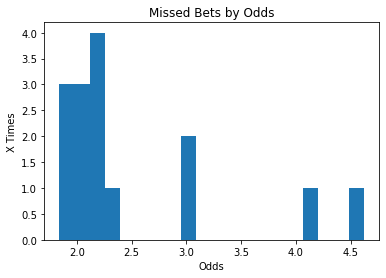

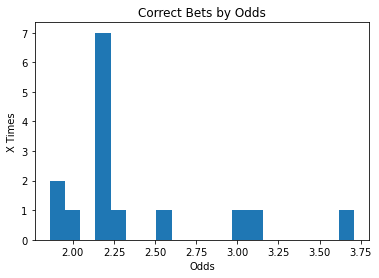

Error when trying to plot the pie chart: 'label' must be of length 'x'
Error when trying to plot the pie chart: 'label' must be of length 'x'


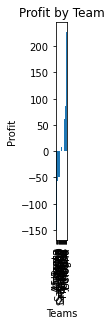

In [644]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away', 'Draw'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away', 'Draw'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

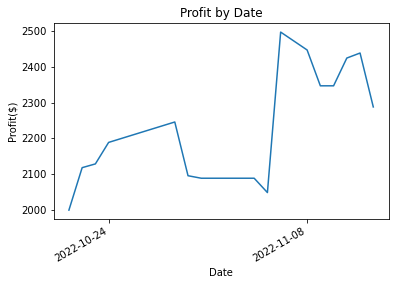

In [645]:
xpoints = money_by_date[:, 0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)

title = "Profit by Date"
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()

In [646]:
from joblib import dump, load

save_current_season_model = False
current_season = 2022

if save_current_season_model:
    result = simulate(current_season)
    dump(result['model'], f'{league_id}/model.joblib')